In [1]:
%load_ext autoreload
%autoreload 2

# Load the Simple Function dataset

In [2]:
from huggingface_hub import hf_hub_download

/home/remi/code/LLM/outlines-func-call-gorilla-leaderboard-experiment/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_path = hf_hub_download(
    repo_id="gorilla-llm/Berkeley-Function-Calling-Leaderboard",
    filename="gorilla_openfunctions_v1_test_simple.json",
    repo_type="dataset",
    revision="9d4f8ce7ec11d4f0e14c820487b14b25ef51dbba" # this code was created against the version of February, new version was released in March
)

In [4]:
import pandas as pd

gorilla_func_call_dataset = df = pd.read_json(file_path, lines=True)

In [5]:
gorilla_func_call_dataset.head()

,question,function,human_eval_answer
0,Find the area of a triangle with a base of 10 ...,"{'name': 'calculate_triangle_area', 'descripti...","calculate_triangle_area(base=10, height=5, uni..."
1,Calculate the factorial of 5 using math functi...,"{'name': 'math.factorial', 'description': 'Cal...",math.factorial(number=5)
2,Calculate the hypotenuse of a right triangle g...,"{'name': 'math.hypot', 'description': 'Calcula...","math.hypot(x=4, y=5)"
3,Find the roots of a quadratic equation with co...,"{'name': 'algebra.quadratic_roots', 'descripti...","algebra.quadratic_roots(a=1, b=-3, c=2)"
4,"Solve a quadratic equation where a=2, b=6, and...","{'name': 'solve_quadratic_equation', 'api_call...","solve_quadratic_equation(a=2, b=6, c=5)"


In [6]:
FUNC_CALL_STR = "human_eval_answer"
JSON_SCHEMA = "function"

# Parse function calls into dict of args

First we define a function that attempts to extract a dictionary out of the expected functionc call.

In [7]:
import ast


def extract_args_from_function_call_string(
    function_call_string, expect_only_keyword_args=True
):
    """
    Extracts arguments from a function call string and returns them in a dict.

    Parameters:
    function_call_str (str): The function call string to extract arguments from
    expect_only_keyword_args (bool): [default: True]

    Returns:
    dict: A dictionary containing argument names as keys and their values.
    """
    # Parse the string to an AST node
    node = ast.parse(function_call_string, mode="eval")

    # Initialize an empty dictionary to store arguments
    args_dict = {}

    # Assuming the structure is a Call, traverse the arguments
    if isinstance(node.body, ast.Call):
        for i, arg in enumerate(node.body.args):
            if expect_only_keyword_args:
                raise ValueError(
                    "Expected only keyword arguments but found positional arguments:",
                    human_eval_str,
                )
            else:
                print("[WARNING] this code path has not been tested")
                if isinstance(arg, ast.Constant):
                    args_dict[i] = arg.value
        for keyword in node.body.keywords:
            # Handle keyword arguments
            if isinstance(keyword.value, ast.Constant):
                args_dict[keyword.arg] = keyword.value.value

            elif isinstance(keyword.value, (ast.List, ast.Tuple)):
                # Handle lists and tuples
                list_values = []
                for elem in keyword.value.elts:
                    if isinstance(elem, ast.UnaryOp):
                        if isinstance(elem.op, ast.USub):
                            list_values.append(-elem.operand.value)
                        elif isinstance(elem.op, ast.UAdd):
                            list_values.append(elem.operand.value)
                    elif isinstance(elem, ast.Constant):
                        list_values.append(elem.value)
                    elif isinstance(elem, ast.Tuple):
                        tuple_values = tuple(sub_elem.value for sub_elem in elem.elts)
                        list_values.append(tuple_values)
                    args_dict[keyword.arg] = list_values

            elif isinstance(keyword.value, ast.UnaryOp) and isinstance(
                keyword.value.operand, ast.Constant
            ):
                # Handle negative numbers
                args_dict[keyword.arg] = -keyword.value.operand.value
            elif isinstance(keyword.value, ast.Dict):
                # Handle dictionaries
                dict_values = {}
                for key, value in zip(keyword.value.keys, keyword.value.values):
                    if isinstance(key, ast.Constant) and isinstance(value, ast.List):
                        list_values = []
                        for elem in value.elts:
                            if isinstance(elem, ast.Constant):
                                list_values.append(elem.value)
                            elif isinstance(elem, ast.UnaryOp):
                                if isinstance(elem.op, ast.USub):
                                    list_values.append(-elem.operand.value)
                                elif isinstance(elem.op, ast.UAdd):
                                    list_values.append(elem.operand.value)
                        dict_values[key.value] = list_values
                    elif isinstance(key, ast.Constant) and isinstance(
                        value, ast.Constant
                    ):
                        dict_values[key.value] = value.value
                args_dict[keyword.arg] = dict_values

        return args_dict

## Dateset issues for the "human_eval_answer"

`
EDIT: There some issues in the dataset, those are the first ones I encountered, there's more down the road1)

In [8]:
print("🟢 recovering errors...")

# original was
# calculate_compounded_interest(principal=4999, interest_rate=0.05, period=10
# ❌ SyntaxError: '(' was never closed
df.loc[145, FUNC_CALL_STR] = (
    "calculate_compounded_interest(principal=5000, interest_rate=0.05, period=10)"
)

# original was:
# crime_statute_lookup(jurisdiction='California', crime='theft'')^
# ❌ SyntaxError: unterminated string literal (detected at line
df.loc[161, FUNC_CALL_STR] = (
    "crime_statute_lookup(jurisdiction='California', crime='theft')"
)
p   

# original was
# get_prime_factors(number=450, formatted=true)
# ❌ true should be True
df.loc[17, FUNC_CALL_STR] = "get_prime_factors(number=450, formatted=True)"

🟢 recovering errors...


## Check arg extract works

In [73]:
VERIF = False

if VERIF:
    for i, row in gorilla_func_call_dataset.iterrows():
        func_call_str = row["human_eval_answer"]
        print(f"[INPUT #{i}]", func_call_str)
        print(" ", func_call_str.split("(", maxsplit=1)[1].replace("=", " =  "))
        args = extract_args_from_function_call_string(func_call_str)
        print(f"[OUTPUT]", args)
        print("\n\n")

## Checking Correctness of the function schema column

In [10]:
from pathlib import Path
import json

tmp = Path("/tmp")

json_schema = df.loc[0, "function"]["parameters"]

with open(tmp / "json_schema.json", "w") as f:
    f.write(json.dumps(json_schema))

here we use a library to generate pydantic base model class out of the json schema

In [11]:
!datamodel-codegen  --input /tmp/json_schema.json --input-file-type jsonschema --output /tmp/model.py

In [12]:
pydantic_models_dir = Path(".").resolve() / "pydantic_models"
pydantic_models_dir.mkdir(exist_ok=True, parents=True)

In [13]:
DONT_RUN = False

get_model_file = lambda i: pydantic_models_dir / f"model_{i}.py"

for i, _ in df.iterrows():
    if DONT_RUN:
        break
    json_schema = df.loc[i, "function"]["parameters"]
    with open(tmp / "json_schema.json", "w") as f:
        f.write(json.dumps(json_schema))
    model_file = get_model_file(i)
    !datamodel-codegen  --input /tmp/json_schema.json --input-file-type jsonschema --output { model_file }

In [14]:
import sys
import importlib.util
from pathlib import Path


def import_model_from_path(file_path: Path):
    # Ensure the directory of the file is in sys.path
    module_dir = file_path.parent
    if str(module_dir) not in sys.path:
        sys.path.append(str(module_dir))

    # Create a module spec from the file location
    spec = importlib.util.spec_from_file_location(file_path.stem, file_path)
    if spec is None:
        raise ImportError(f"Could not load spec for module at {file_path}")

    # Load the module from spec
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Access the Model object
    if hasattr(module, "Model"):
        return getattr(module, "Model")
    else:
        raise AttributeError(
            f"Module at {file_path} does not have an object named 'Model'"
        )


Model = import_model_from_path(get_model_file(0))

In [15]:
Model

model_0.Model

In [16]:
args = extract_args_from_function_call_string(df.iloc[0][FUNC_CALL_STR])
args

{'base': 10, 'height': 5, 'unit': 'units'}

In [17]:
call_string = df.iloc[0][FUNC_CALL_STR]
call_string

"calculate_triangle_area(base=10, height=5, unit='units')"

In [18]:
extract_args_from_function_call_string(call_string)

{'base': 10, 'height': 5, 'unit': 'units'}

In [19]:
import json

json_args = json.dumps(args)

In [20]:
Model.model_validate_json(json_args)

Model(base=10.0, height=5.0, unit='units')

In [21]:
df.loc[59, JSON_SCHEMA]["parameters"]["required"] = [
    "compound"
]  # `to_unit is not required`
df.loc[77, FUNC_CALL_STR] = (
    "restaurant.find_nearby(location='Los Angeles, CA', dietary_preference=['Vegan'])"  # the field is annotated as an array of enum, not an enum
)
# df.loc[99] is illformed

In [24]:
DATASET_ISSUES = [59, 77, 99, 109, 166, 206, 234, 243, 248, 342, 350]
N_FIXED = 0
ILL_ROWS = {
    99: "reason: requires to execute code before answering the question, hence is not simple func call",
    109: "reason: requires to have access to a variable defined elsewhere",
    "others": "I got bored. I give up.",
}

VERIF2 = False # Set to true to verify the parsing
if VERIF2:
    for i, row in df.iterrows():
        if i in DATASET_ISSUES[N_FIXED:] or i in ILL_ROWS:
            continue

        model = import_model_from_path(get_model_file(i))
        call_string = row[FUNC_CALL_STR]
        args = extract_args_from_function_call_string(call_string)
        continue
        print(i, call_string, args)
        print(model(**args))
        print()

# Benchmark

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from textwrap import dedent

In [25]:
import nest_asyncio

nest_asyncio.apply()

This requires to have vLLM running (vLLM has an outlines integration)

```python
python -m vllm.entrypoints.openai.api_server --model TheBloke/Mistral-7B-Instruct-v0.2-AWQ --host 0.0.0.0 --port 8000 --dtype auto --quantization awq --max-model-len 8192 --max-num-seqs 32
```

In [26]:
from openai import AsyncOpenAI

CONFIG__MODEL = "TheBloke/Mistral-7B-Instruct-v0.2-AWQ"
CONFIG__VLLM_BASE_URL = "http://localhost:8000/v1"
CONFIG__API_TOKEN = "required_yet_unuesed_argument"

client = AsyncOpenAI(base_url=CONFIG__VLLM_BASE_URL, api_key=CONFIG__API_TOKEN)

In [38]:
get_text = lambda x: x.choices[0].text

In [27]:
prompt_template = dedent(
            """\
        <s>[INST]
        A user is gonna ask you a question, you need to extract the arguments to be passed to the function that can answer the question.
        You must answer the user's question by replying VALID JSON that matches the schema below:
        
        ```json
        {schema}
        ```
        
        ---
        
        The user's question below
        
        ```text
        {user_query}
        ```
        
        [/INST]
        ```json
        """)

In [31]:
print(prompt_template.format(schema="xxx", user_query="xxx"))

<s>[INST]
A user is gonna ask you a question, you need to extract the arguments to be passed to the function that can answer the question.
You must answer the user's question by replying VALID JSON that matches the schema below:

```json
xxx
```

---

The user's question below

```text
xxx
```

[/INST]
```json



In [43]:
# build the dataset
DATASET_ISSUES = [59, 77, 99, 109, 166, 206, 234, 243, 248, 342, 350]
N_FIXED = 0
ILL_ROWS = {
    99: "reason: requires to execute code before answering the question, hence is not simple func call",
    109: "reason: requires to have access to a variable defined elsewhere",
    "others": "I got bored. I give up.",
}

from dataclasses import dataclass
from pydantic import BaseModel


@dataclass
class DatasetEntry:
    id: int
    question: str
    model: BaseModel
    json_schema: str
    correct: dict


dataset = []

for i, row in df.iterrows():
    if i in DATASET_ISSUES[N_FIXED:] or i in ILL_ROWS:
        continue

    model = import_model_from_path(get_model_file(i))
    call_string = row[FUNC_CALL_STR]
    args = extract_args_from_function_call_string(call_string)

    dataset.append(
        DatasetEntry(
            id=i,
            question=row["question"],
            model=model,
            correct=args,
            json_schema=row[JSON_SCHEMA]["parameters"],
        )
    )

In [44]:
print("Checking this works.")

res = await client.completions.create(
    model=CONFIG__MODEL,
    prompt=prompt_template.format(schema=dataset[1].json_schema, user_query=dataset[1].question),
    max_tokens=2048,
    extra_body={"guided_json": dataset[1].json_schema}  # this enables OUTLINES on vLLM' side
)

get_text(res)

'{"number": 5}'

In [67]:
from pydantic import ValidationError
from openai import InternalServerError
import asyncio

valid = []
correct = []
invalid = []


async def benchmark_one_row(i):
    try:
        res = await client.completions.create(
            model=CONFIG__MODEL,
            prompt=prompt_template.format(
                schema=dataset[i].json_schema, user_query=dataset[i].question
            ),
            max_tokens=1024,
            extra_body={"guided_json": dataset[i].json_schema},
        )
    except InternalServerError as e:
        print(i, "crashed the server")
        print(e)
        print()
        return
    else:
        try:
            pred = dataset[i].model.model_validate_json(get_text(res))
            valid.append(i)
            if pred == dataset[i].model(**dataset[i].correct):
                correct.append(i)
        except ValidationError as e:
            print(e)
            invalid.append(i)
    

benchmark = (benchmark_one_row(i) for i in range(len(dataset)))

results = await asyncio.gather(*benchmark)

print(len(valid))
print(len(invalid))
print(len(correct))

111 crashed the server
Internal Server Error

81 crashed the server
Internal Server Error

120 crashed the server
Internal Server Error

378 crashed the server
Internal Server Error

328 crashed the server
Internal Server Error

1 validation error for Model
  Invalid JSON: invalid escape at line 3 column 370 [type=json_invalid, input_value='{"chords":6\n   ,"key": ... "                    }', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
1 validation error for Model
  Invalid JSON: EOF while parsing a string at line 3 column 2050 [type=json_invalid, input_value='{\n  "end_location": "Me..., , , , , , , , , , , ,', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/json_invalid
1 validation error for Model
  Invalid JSON: EOF while parsing an object at line 3 column 1014 [type=json_invalid, input_value='{\n  "species": "Homo Sa...11111111111111111111111', input_type=str]
    For further information visit

In [68]:
print(len(valid))
print(len(invalid))
print(len(correct))

381
3
230


In [69]:
INVALID_JSON_SCHEMA = {81, 111, 120, 328, 378}  # crashes the server

In [70]:
len_dataset = len(dataset) - len(INVALID_JSON_SCHEMA)

In [71]:
accuracy = len(correct) / len_dataset

In [72]:
print(accuracy)

0.5989583333333334


# first impression:

woh 60% accuracy without even trying hard is good:

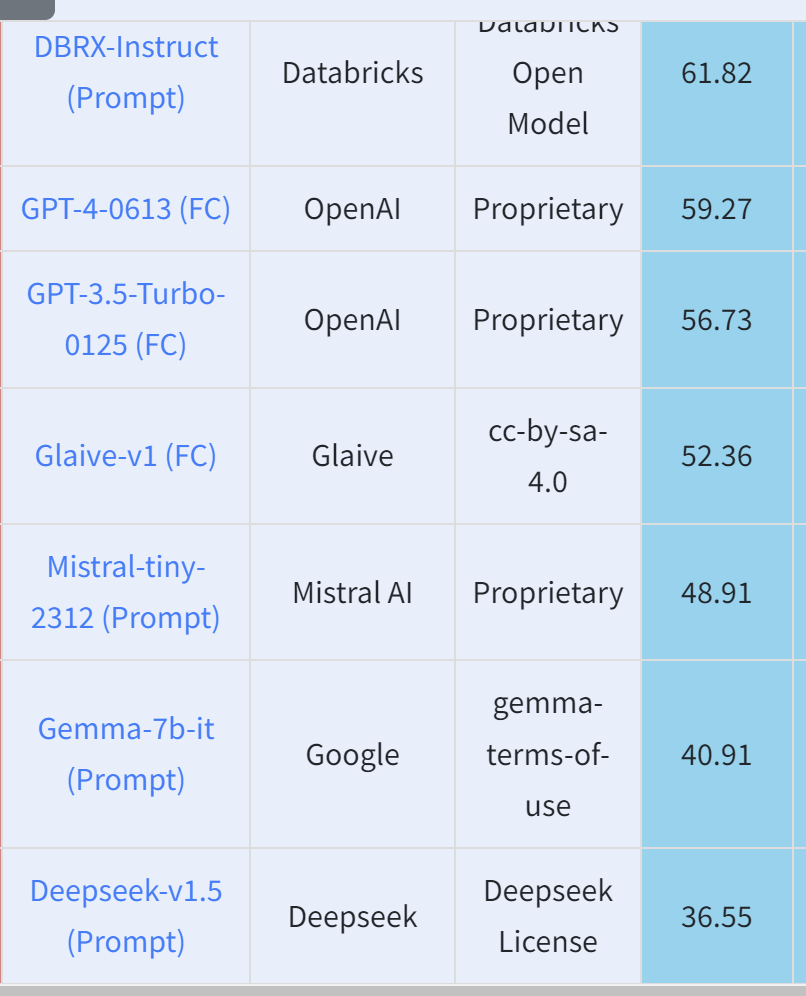

https://gorilla.cs.berkeley.edu/leaderboard.html (click on expand table, sort by AST.Simple (the category of the dataset we are in)) 

This would mean; that outlines + mistral 7b gets a better score than all those and arrive just below DBRX (prompt, no fc)
And beats FC  (function calling) version of old version of GPT4,  GPT3.5 and Glaive, which is rather impressive for a 7b model, isn't it?